# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt

import matplotlib.dates as dt

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import time
from datetime import datetime, timedelta


Using TensorFlow backend.


# Load Datasets

In [ ]:
df_confirmed = pd.read_csv("../input/ece657aw20asg4coronavirus/time_series_covid19_confirmed_global.csv")
df_recovered = pd.read_csv("../input/ece657aw20asg4coronavirus/time_series_covid19_recovered_global.csv")
df_deaths = pd.read_csv("../input/ece657aw20asg4coronavirus/time_series_covid19_deaths_global.csv")


In [ ]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,14,15,15,18,18,21,23,25,30,30
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,22,23,23,23,23,23,24,25,26,26
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,205,235,256,275,293,313,326,336,348,364
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,23,25,26,26,29,29,31,33,33,35
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


# Data preprocessing

We drop the unwanted columns which we won't be using for our neural network computations.

In [ ]:
def restructure(df):
    df['Country'] = df['Country/Region'].map(str) + '_' + df['Province/State'].map(str)
    df =  df.drop(['Province/State', 'Country/Region' , 'Lat' , 'Long'], axis=1)
    df = df.set_index('Country')
    df = df.T
    df = df.fillna(0)
    return df

Next, we take each dataset for confirmed cases, recovered cases and deaths and convert them into a time-series dataframe

In [ ]:
# Create dataframes for each category
confirmed = restructure(df_confirmed)
confirmed.index = pd.to_datetime(confirmed.index)

recovered = restructure(df_recovered)
recovered.index = pd.to_datetime(recovered.index)

deaths = restructure(df_deaths)
deaths.index = pd.to_datetime(deaths.index)

# Create dataframes for the world
world_conf = confirmed.sum(axis=1)
world_recv = recovered.sum(axis=1)
world_dead = deaths.sum(axis=1)

In [ ]:
world_conf.tail()

2020-04-13    1904838
2020-04-14    1976191
2020-04-15    2056054
2020-04-16    2152646
2020-04-17    2240190
dtype: int64

# Plots

We plot the cases in 3 countries and also plot total worldwide cases

In [ ]:
# Creating a new dataframe for Countries
italy = pd.DataFrame()
india = pd.DataFrame()
germany = pd.DataFrame()

italy['Confirmed'] = confirmed['Italy_nan']
italy['Recovered'] = recovered['Italy_nan']
italy['Deaths'] = deaths['Italy_nan']


india['Confirmed'] = confirmed['India_nan']
india['Recovered'] = recovered['India_nan']
india['Deaths'] = deaths['India_nan']

germany['Confirmed'] = confirmed['Germany_nan']
germany['Recovered'] = recovered['Germany_nan']
germany['Deaths'] = deaths['Germany_nan']



/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


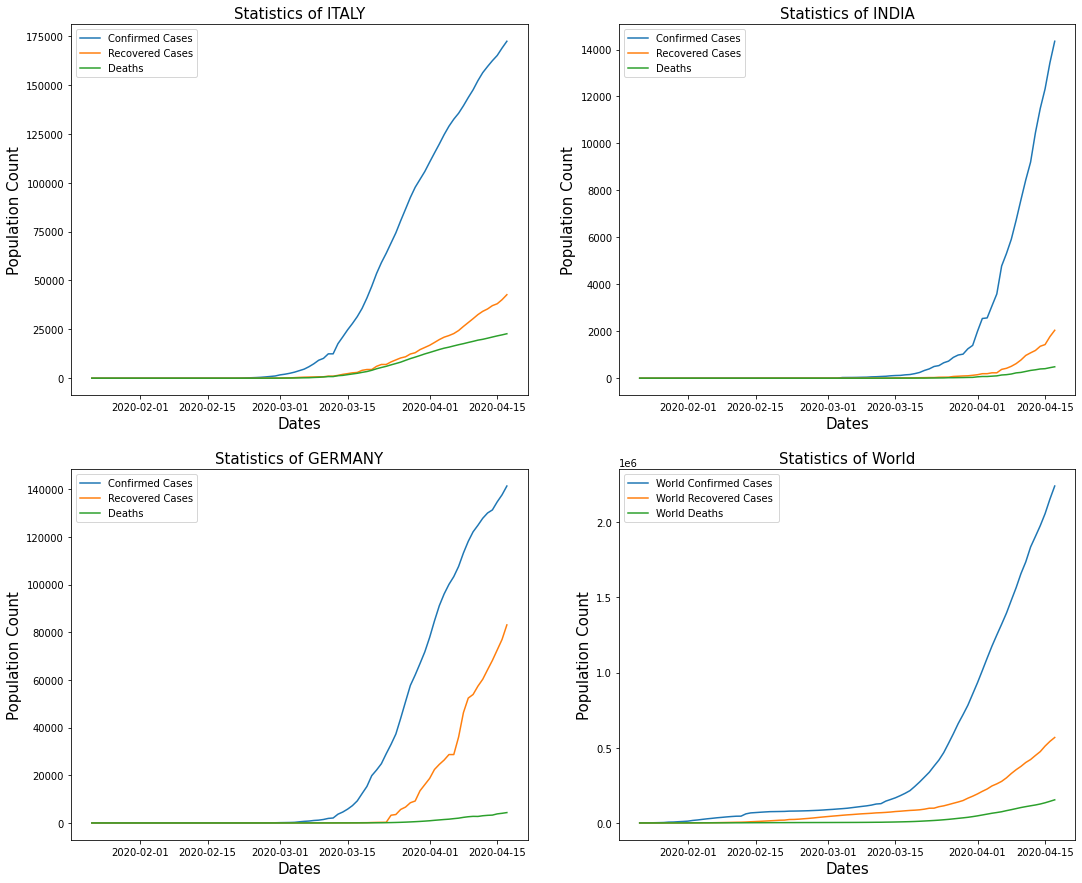

In [ ]:
# Plots for Italy, India, Germany and The WORLD
fig = plt.figure(figsize=(18,15))

plt.subplot(2,2,1)
plt.plot(italy.Confirmed, label='Confirmed Cases')
plt.plot(italy.Recovered, label='Recovered Cases')
plt.plot(italy.Deaths, label='Deaths')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Population Count', fontsize=15)
plt.title('Statistics of ITALY', fontsize=15)
plt.legend()

plt.subplot(2,2,2)
plt.plot(india.Confirmed, label='Confirmed Cases')
plt.plot(india.Recovered, label='Recovered Cases')
plt.plot(india.Deaths, label='Deaths')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Population Count', fontsize=15)
plt.title('Statistics of INDIA', fontsize=15)
plt.legend()

plt.subplot(2,2,3)
plt.plot(germany.Confirmed, label='Confirmed Cases')
plt.plot(germany.Recovered, label='Recovered Cases')
plt.plot(germany.Deaths, label='Deaths')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Population Count', fontsize=15)
plt.title('Statistics of GERMANY', fontsize=15)
plt.legend()

plt.subplot(2,2,4)
plt.plot(world_conf.iloc[:], label='World Confirmed Cases ')
plt.plot(world_recv.iloc[:], label='World Recovered Cases')
plt.plot(world_dead.iloc[:], label='World Deaths')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Population Count', fontsize=15)
plt.title('Statistics of World', fontsize=15)
plt.legend()

Now we plot Global Top 10 regions in each category

Text(0.5, 1.0, 'Deaths in most affected areas')

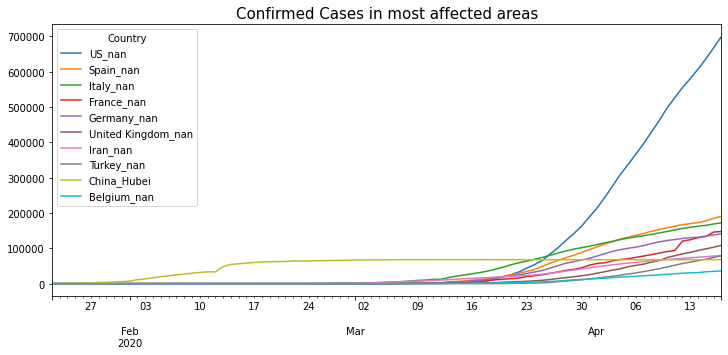

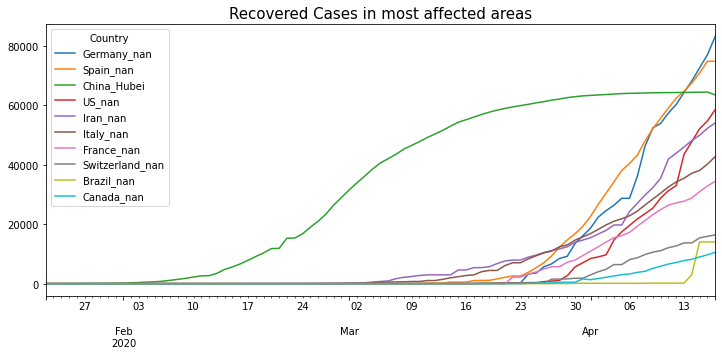

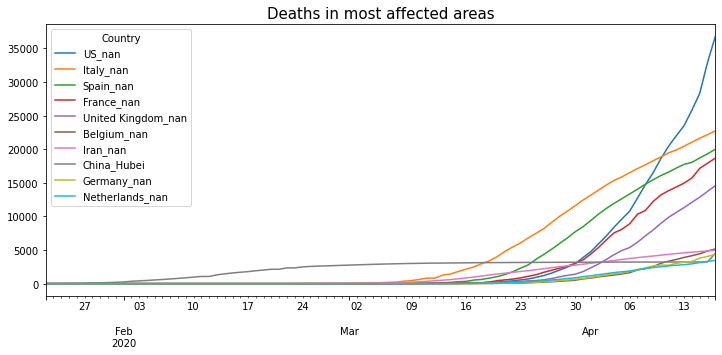

In [ ]:
# Plot Global top 10 regions

# fig = plt.figure(figsize=(12,18))

conf_sort = confirmed.reindex(confirmed.max().sort_values(ascending=False).index, axis=1)
conf_top = conf_sort.iloc[:,0:10]

rec_sort = recovered.reindex(recovered.max().sort_values(ascending=False).index, axis=1)
rec_top = rec_sort.iloc[:,0:10]

dead_sort = deaths.reindex(deaths.max().sort_values(ascending=False).index, axis=1)
dead_top = dead_sort.iloc[:,0:10]

conf_top.plot(figsize=(12,5))
plt.title('Confirmed Cases in most affected areas', fontsize=15)

rec_top.plot(figsize=(12,5))
plt.title('Recovered Cases in most affected areas', fontsize=15)

dead_top.plot(figsize=(12,5))
plt.title('Deaths in most affected areas', fontsize=15)

# Italy

Here, we will be training an LSTM Model on our time-series data.
We will split our data in each category into train and test. <br>
Then we will try training our model and plot the predicted train and test values. <br>
Once satisfied with the performance, we will use the same model to compute future trends and predict the spread of virus among the population for a set number of days.

In [ ]:
italy.tail()

,Confirmed,Recovered,Deaths
2020-04-13,159516,35435,20465
2020-04-14,162488,37130,21067
2020-04-15,165155,38092,21645
2020-04-16,168941,40164,22170
2020-04-17,172434,42727,22745


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    print(len(dataset))
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
        
    return np.array(dataX), np.array(dataY)

In [ ]:
italy_confirmed = italy.iloc[:,0]

italy_recovered = italy.iloc[:,1]

italy_dead = italy.iloc[:,2]

### For Confirmed Cases

In [ ]:
# Split the series for training and testing
size = italy_confirmed.shape[0]
tr =int(round(size*0.8))
X_train, X_test = italy_confirmed[:tr] , italy_confirmed[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create train and test windows
look_back = 6
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


70
17


Train the LSTM Model

In [ ]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(30, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               165600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 165,801
Trainable params: 165,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
63/63 [==============================] - 0s 8ms/step - loss: 570042524.3366
Epoch 2/20
63/63 [==============================] - 0s 2ms/step - loss: 127846441.9484
Epoch 3/20
63/63 [==============================] - 0s 2ms/step - loss: 131792900.8028
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 78430643.8607
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 57601279.4207
Epoch 6/20
63/63 [==============================] - 0s 2ms/step - loss: 61527

In [ ]:
# Make predictions using LSTM Model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
size = len(italy_confirmed)

# Create NULL arrays
trainPredictPlot = np.zeros(size)
testPredictPlot = np.zeros(size)

for i in range(size):
    trainPredictPlot[i] = np.nan
    testPredictPlot[i] = np.nan

# Add predicted values to new arrays

for i in range(len(trainPredict)):
    trainPredictPlot[look_back + i] = trainPredict[i]

for i in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+(look_back*2)+ i : size-1] = testPredict[i]

# Create Dataframes for each and merge everything
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Train Predictions'])
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Test Predictions'])

italy_conf = pd.DataFrame(italy_confirmed.values.astype("float"), columns=['Actual Confirmed'])
italy_conf = italy_conf.join(trainPredictPlot)
italy_conf = italy_conf.join(testPredictPlot)
italy_conf.index = italy_confirmed.index

### Future predictions

In [ ]:
dates_range = 15
italy_conf_preds= italy_confirmed.copy()
length = italy_confirmed.shape[0]
italy_conf_preds = italy_conf_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(italy.index[-1], periods=31)

for i in range(dates_range-1):
    col = italy_conf_preds['Confirmed']
    value = col[-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Confirmed'] )
    italy_conf_preds = italy_conf_preds.append(df, ignore_index=True)

italy_conf_preds = italy_conf_preds.set_index('index')

In [ ]:
italy_conf_preds.tail()

,Confirmed
index,
2020-04-27,310460.31250
2020-04-28,327636.65625
2020-04-29,345702.96875
2020-04-30,364459.53125
2020-05-01,384098.34375


### For Recovered Cases

In [ ]:
# Split the series for training and testing
size = italy_recovered.shape[0]
tr =int(round(size*0.8))
X_train, X_test = italy_recovered[:tr] , italy_recovered[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)


# Create Windows
look_back = 6
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

70
17


In [ ]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(40, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 40)                7520      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 7,561
Trainable params: 7,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
63/63 [==============================] - 0s 8ms/step - loss: 17699523.3893
Epoch 2/20
63/63 [==============================] - 0s 2ms/step - loss: 14984826.6688
Epoch 3/20
63/63 [==============================] - 0s 2ms/step - loss: 11797208.2893
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 6321388.0336
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 715400.5900
Epoch 6/20
63/63 [==============================] - 0s 2ms/step - loss: 1659632.2059
Ep

In [ ]:
# Make predictions using LSTM Model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
size = len(italy_recovered)

# Create NULL arrays
trainPredictPlot = np.zeros(size)
testPredictPlot = np.zeros(size)

for i in range(size):
    trainPredictPlot[i] = np.nan
    testPredictPlot[i] = np.nan

# Add predicted values to new arrays

for i in range(len(trainPredict)):
    trainPredictPlot[look_back + i] = trainPredict[i]

for i in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+(look_back*2)+ i : len(italy_recovered)-1] = testPredict[i]

# Create Dataframes for each and merge everything
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Train Predictions'])
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Test Predictions'])

italy_recv = pd.DataFrame(italy_recovered.values.astype("float"), columns=['Actual Confirmed'])
italy_recv = italy_recv.join(trainPredictPlot)
italy_recv = italy_recv.join(testPredictPlot)
italy_recv.index = italy_recovered.index

### Future Predictions

In [ ]:
dates_range = 15
italy_recv_preds= italy_recovered.copy()
length = italy_recovered.shape[0]
italy_recv_preds = italy_recv_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(italy.index[-1], periods=31)

for i in range(dates_range-1):
    col = italy_recv_preds['Recovered']
    value = col[-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Recovered'] )
    italy_recv_preds = italy_recv_preds.append(df, ignore_index=True)

italy_recv_preds = italy_recv_preds.set_index('index')

In [ ]:
italy_recv_preds.tail()

,Recovered
index,
2020-04-27,78059.531250
2020-04-28,82844.609375
2020-04-29,87900.062500
2020-04-30,93244.000000
2020-05-01,98908.625000


### For Deaths

In [ ]:
# Split the series for training and testing
size = italy_dead.shape[0]
tr =int(round(size*0.8))
X_train, X_test = italy_dead[:tr] , italy_dead[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)


# Create windows
look_back = 6
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

70
17


In [ ]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(200, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               165600    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 165,801
Trainable params: 165,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 8123411.0149
Epoch 2/20
63/63 [==============================] - 0s 2ms/step - loss: 862243.5430
Epoch 3/20
63/63 [==============================] - 0s 2ms/step - loss: 700033.9803
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 294480.3203
Epoch 5/20
63/63 [==============================] - 0s 2ms/step - loss: 867363.1868
Epoch 6/20
63/63 [==============================] - 0s 2ms/step - loss: 753886.6113
Epoch

In [ ]:
# Make predictions using LSTM Model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
size = len(italy_dead)

# Create NULL arrays
trainPredictPlot = np.zeros(size)
testPredictPlot = np.zeros(size)

for i in range(size):
    trainPredictPlot[i] = np.nan
    testPredictPlot[i] = np.nan

# Add predicted values to new arrays

for i in range(len(trainPredict)):
    trainPredictPlot[look_back + i] = trainPredict[i]

for i in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+(look_back*2)+ i : len(italy_dead)-1] = testPredict[i]

# Create Dataframes for each and merge everything
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Train Predictions'])
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Test Predictions'])

italy_deads = pd.DataFrame(italy_dead.values.astype("float"), columns=['Actual Deaths'])
italy_deads = italy_deads.join(trainPredictPlot)
italy_deads = italy_deads.join(testPredictPlot)
italy_deads.index = italy_dead.index

### Future Predictions

In [ ]:
dates_range = 15
italy_dead_preds= italy_dead.copy()
length = italy_dead.shape[0]
italy_dead_preds = italy_dead_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(italy.index[-1], periods=31)

for i in range(dates_range-1):
    col = italy_dead_preds['Deaths']
    value = col[-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Deaths'] )
    italy_dead_preds = italy_dead_preds.append(df, ignore_index=True)

italy_dead_preds = italy_dead_preds.set_index('index')

In [ ]:
italy_dead_preds.tail()

,Deaths
index,
2020-04-27,40525.878906
2020-04-28,42759.781250
2020-04-29,45113.421875
2020-04-30,47564.785156
2020-05-01,50133.625000


# Plots for Italy

We generate plots for Italy. <br>
On the left, we plotted the Trained and tested predictions with the actual values for each category. <br>

On the right, we plotted the predicted future trends of the virus in Italy along with the actual values. Actual values stop at one point, which is the point until when the data was collected.

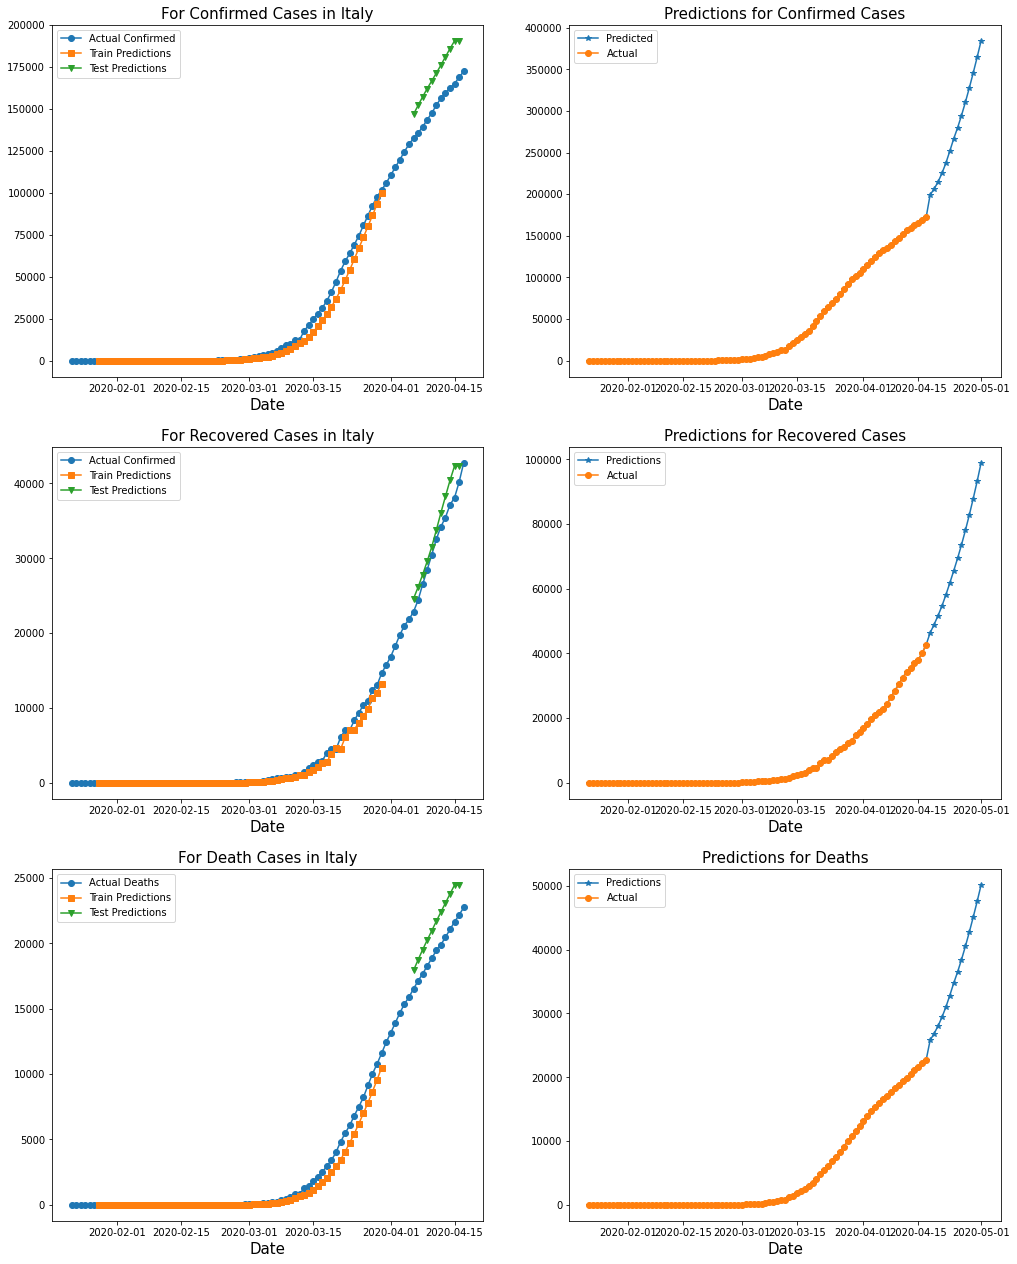

In [ ]:
# plot Confirmed actual cases and predictions
fig = plt.figure(figsize=(17,22))

plt.subplot(3,2,1)
plt.plot(italy_conf.iloc[:,0], label=italy_conf.iloc[:,0].name, marker='o')
plt.plot(italy_conf.iloc[:,1], label=italy_conf.iloc[:,1].name, marker='s')
plt.plot(italy_conf.iloc[:,2], label=italy_conf.iloc[:,2].name, marker='v')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('For Confirmed Cases in Italy', fontsize=15)
plt.legend()


plt.subplot(3,2,2)
plt.plot(italy_conf_preds.Confirmed, label='Predicted', marker='*')
plt.plot(italy_conf.iloc[:,0], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('Predictions for Confirmed Cases', fontsize=15)
plt.legend()

# plot Recovered actual cases and predictions
plt.subplot(3,2,3)
plt.plot(italy_recv.iloc[:,0], label=italy_recv.iloc[:,0].name, marker='o')
plt.plot(italy_recv.iloc[:,1], label=italy_recv.iloc[:,1].name, marker='s')
plt.plot(italy_recv.iloc[:,2], label=italy_recv.iloc[:,2].name, marker='v')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('For Recovered Cases in Italy', fontsize=15)
plt.legend()

plt.subplot(3,2,4)
plt.plot(italy_recv_preds.Recovered, label='Predictions', marker='*')
plt.plot(italy_recv.iloc[:,0], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('Predictions for Recovered Cases', fontsize=15)
plt.legend()

# plot actual Deaths and predictions
plt.subplot(3,2,5)
plt.plot(italy_deads.iloc[:,0], label=italy_deads.iloc[:,0].name, marker='o')
plt.plot(italy_deads.iloc[:,1], label=italy_deads.iloc[:,1].name, marker='s')
plt.plot(italy_deads.iloc[:,2], label=italy_deads.iloc[:,2].name, marker='v')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('For Death Cases in Italy', fontsize=15)
plt.legend()

plt.subplot(3,2,6)
plt.plot(italy_dead_preds.Deaths, label='Predictions', marker='*')
plt.plot(italy_deads.iloc[:,0], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
plt.title('Predictions for Deaths', fontsize=15)
plt.legend()

# World

Now we shift our focus to the World demographics that are affected by COVID-19. <br>

We tune our LSTM model for the world data, generate predictions and plot those predictions against the actual values.<br>
These predictions generated try to foresee the next 20 days of disease spread, until April 22, 2020.

In [ ]:
world_confirmed = pd.DataFrame(world_conf)
world_confirmed = world_confirmed.rename(columns={0: 'Confirmed'})

world_recovered = pd.DataFrame(world_recv)
world_recovered = world_recovered.rename(columns={0: 'Recovered'})

world_dead = pd.DataFrame(world_dead)
world_dead = world_dead.rename(columns={0: 'Deaths'})


In [ ]:
world_confirmed.tail()

,Confirmed
2020-04-13,1904838
2020-04-14,1976191
2020-04-15,2056054
2020-04-16,2152646
2020-04-17,2240190


## For Worldwide Confirmed Cases

In [ ]:
# Split the series for training and testing
size = world_confirmed.shape[0]
tr =int(round(size*0.8))
X_train, X_test = world_confirmed[:tr] , world_confirmed[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create train and test windows
look_back = 12
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


70
17


In [ ]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(30, input_shape=(1, look_back), activation='relu', dropout=0.3))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30)                5160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 5,191
Trainable params: 5,191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
57/57 [==============================] - 0s 8ms/step - loss: 53881664523.2281
Epoch 2/20
57/57 [==============================] - 0s 2ms/step - loss: 38732678714.3860
Epoch 3/20
57/57 [==============================] - 0s 2ms/step - loss: 34493909016.1404
Epoch 4/20
57/57 [==============================] - 0s 2ms/step - loss: 20764028079.3741
Epoch 5/20
57/57 [==============================] - 0s 2ms/step - loss: 12328938220.0658
Epoch 6/20
57/57 [==============================] - 0s 2ms/step - los

In [ ]:
dates_range = 20
world_conf_preds= world_confirmed.copy()
length = world_confirmed.shape[0]
world_conf_preds = world_conf_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(world_conf.index[-1], periods=dates_range)

for i in range(dates_range-1):
    value = world_conf_preds.iloc[:,1][-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Confirmed'] )
    world_conf_preds = world_conf_preds.append(df, ignore_index=True)

world_conf_preds = world_conf_preds.set_index('index')

In [ ]:
world_conf_preds.tail()

,Confirmed
index,
2020-05-02,5924185.0
2020-05-03,7537271.0
2020-05-04,6433108.5
2020-05-05,11228020.0
2020-05-06,12905401.0


## For Worldwide Recovered Cases

In [ ]:
# Split the series for training and testing
size = world_recovered.shape[0]
tr =int(round(size*0.8))
X_train, X_test = world_recovered[:tr] , world_recovered[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create train and test windows
look_back = 12
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


70
17


In [ ]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(40, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 40)                8480      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 8,521
Trainable params: 8,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
57/57 [==============================] - 0s 8ms/step - loss: 2532893886.1689
Epoch 2/20
57/57 [==============================] - 0s 2ms/step - loss: 699284228.4052
Epoch 3/20
57/57 [==============================] - 0s 2ms/step - loss: 264696784.2660
Epoch 4/20
57/57 [==============================] - 0s 2ms/step - loss: 181667597.9668
Epoch 5/20
57/57 [==============================] - 0s 2ms/step - loss: 245696428.4263
Epoch 6/20
57/57 [==============================] - 0s 2ms/step - loss: 152235

In [ ]:
dates_range = 20
world_recv_preds= world_recovered.copy()
length = world_recovered.shape[0]
world_recv_preds = world_recv_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(world_recv.index[-1], periods=dates_range)

for i in range(dates_range-1):
    value = world_recv_preds.iloc[:,1][-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Recovered'] )
    world_recv_preds = world_recv_preds.append(df, ignore_index=True)

world_recv_preds = world_recv_preds.set_index('index')

In [ ]:
world_recv_preds.tail()

,Recovered
index,
2020-05-02,632775.9375
2020-05-03,733617.6875
2020-05-04,651983.7500
2020-05-05,745726.3125
2020-05-06,673621.2500


## For Worldwide Deaths

In [ ]:
# Split the series for training and testing
size = world_dead.shape[0]
tr =int(round(size*0.8))
X_train, X_test = world_dead[:tr] , world_dead[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create train and test windows
look_back = 7
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


70
17


In [ ]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(30, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30)                4560      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 4,591
Trainable params: 4,591
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
62/62 [==============================] - 0s 8ms/step - loss: 76408831.4993
Epoch 2/20
62/62 [==============================] - 0s 2ms/step - loss: 57171940.9960
Epoch 3/20
62/62 [==============================] - 0s 2ms/step - loss: 45767705.1037
Epoch 4/20
62/62 [==============================] - 0s 2ms/step - loss: 13812175.0992
Epoch 5/20
62/62 [==============================] - 0s 2ms/step - loss: 13972761.9998
Epoch 6/20
62/62 [==============================] - 0s 2ms/step - loss: 9094320.7528

In [ ]:
dates_range = 20
world_dead_preds= world_dead.copy()
length = world_dead.shape[0]
world_dead_preds = world_dead_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(world_dead.index[-1], periods=dates_range)

for i in range(dates_range-1):
    value = world_dead_preds.iloc[:,1][-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Deaths'] )
    world_dead_preds = world_dead_preds.append(df, ignore_index=True)

world_dead_preds = world_dead_preds.set_index('index')

In [ ]:
world_dead_preds.tail()

,Deaths
index,
2020-05-02,405323.96875
2020-05-03,432326.28125
2020-05-04,461141.90625
2020-05-05,491887.68750
2020-05-06,524685.06250


# Plots for the World

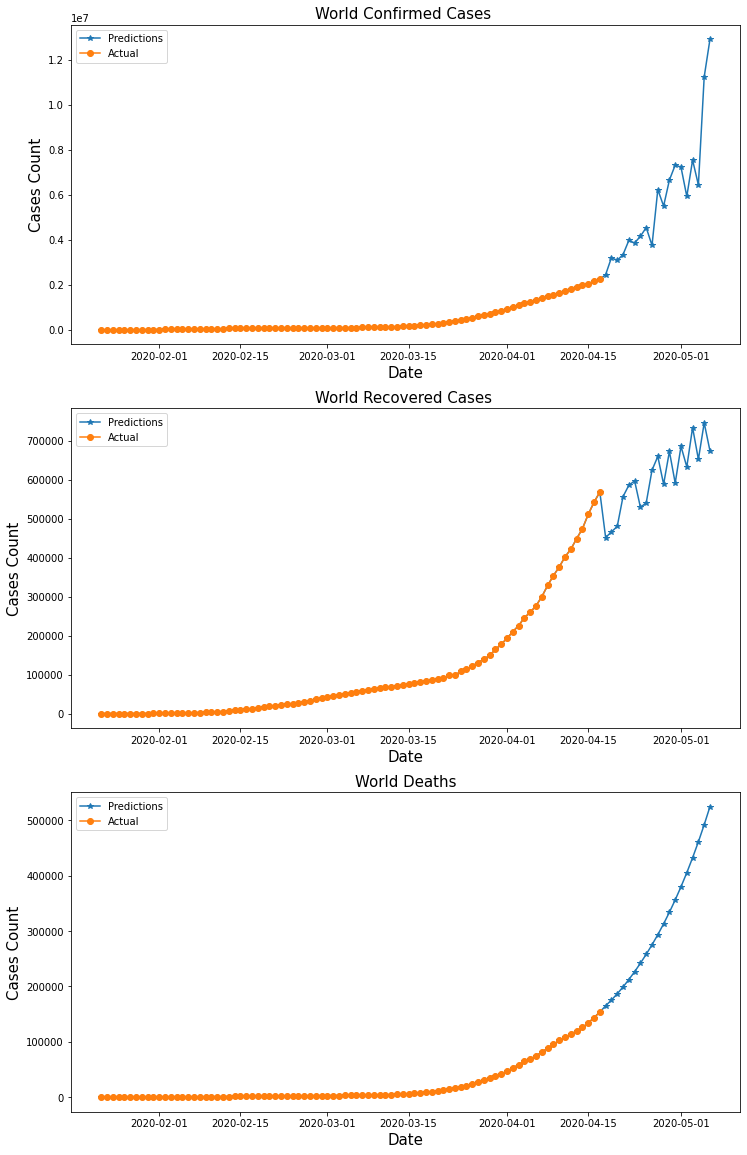

In [ ]:
# plot Confirmed actual cases and predictions
fig = plt.figure(figsize=(12,20))

plt.subplot(3,1,1)
plt.plot(world_conf_preds['Confirmed'], label='Predictions', marker='*')
plt.plot(world_confirmed['Confirmed'], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cases Count', fontsize=15)
plt.title('World Confirmed Cases ', fontsize=15)
plt.legend()


plt.subplot(3,1,2)
plt.plot(world_recv_preds['Recovered'], label='Predictions', marker='*')
plt.plot(world_recovered['Recovered'], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cases Count', fontsize=15)
plt.title('World Recovered Cases ', fontsize=15)
plt.legend()

plt.subplot(3,1,3)
plt.plot(world_dead_preds['Deaths'], label='Predictions', marker='*')
plt.plot(world_dead['Deaths'], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cases Count', fontsize=15)
plt.title('World Deaths', fontsize=15)
plt.legend()

# Final Thoughts

*   The final day for submission of this project was April 22, 2020. So, I used this opportunity to compare our model to real world data and draw insightful comparisons.

*   The Prediction plots of Italy overestimate the spread of the virus. They predict far more confirmed cases, recovered cases and deaths than in real life. But my model does a good job of estimating the increasing trend that is observed in real life as well.

*   For the World Predictions, I noticed a similar trend that is happening in the world right now. The numbers are continuing to increase, but let's hope that my model is wrong and this pandemic ends soon!